In [1]:
import os
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from MachineLearningUtils import plot_confustion_matrix, error_rate
from sklearn.model_selection import RandomizedSearchCV
import pickle
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score

# import data

In [2]:
df_train = pd.read_pickle('../data/df_train.pkl.gzip', compression='gzip')
df_test = pd.read_pickle('../data/df_test.pkl.gzip', compression='gzip')

In [3]:
df = pd.concat([df_train, df_test])

In [4]:
df.shape

(15386, 19)

# Feature Engineer

## Drop unnecessary columns

In [5]:
df.drop(['receiver_latitude', 'receiver_longitude', 'receiver_elevation_m', 'p_arrival_sample', 'p_travel_sec',
         's_arrival_sample', 'source_origin_time', 'source_latitude', 'source_longitude',
         'source_depth_km'], axis=1, inplace=True)

## Spectral Centroid

In [6]:
trace_list = ['E','N','Z']

In [7]:
def spectral_centroid(x, samplerate=44100):
    magnitudes = np.abs(np.fft.rfft(x)) # magnitudes of positive frequencies
    length = len(x)
    freqs = np.abs(np.fft.fftfreq(length, 1.0/samplerate)[:length//2+1]) # positive frequencies
    return np.sum(magnitudes*freqs) / np.sum(magnitudes) # return weighted mean

In [8]:
for tl in trace_list:
    df['spectral_centroid_{}'.format(tl)] = df[tl].apply(spectral_centroid)

## Degree of rectiliniarity (polarization)

In [9]:
from obspy.signal.polarization import flinn

/opt/anaconda3/lib/python3.7/site-packages/obspy/signal/headers.py:93: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ], align=True)


In [10]:
df['rect_azimuth'], df['rect_incidence'], df['rect_rectilinearity'],df['rect_planarity'] = zip(*df.apply(lambda x: flinn([x['Z'],x['N'],x['E']]), axis=1))

## RMS of frequency amplitude

In [11]:
for tl in trace_list:
    df['rms_freq_amp_{}'.format(tl)] = df[tl].apply( lambda x: np.sqrt(np.mean(np.square(np.real(np.fft.fft(x))))))

## Maximum power of frequency amplitude

In [12]:
from scipy import signal

In [13]:
for tl in trace_list:
    df['max_power_freq_amp_{}'.format(tl)] = df[tl].apply(lambda x: np.sqrt(signal.periodogram(x, 100, 'flattop', scaling='spectrum')[1].max()))

## Dominant frequency

In [14]:
from obspy.signal.freqattributes import central_frequency_unwindowed

In [15]:
for tl in trace_list:
    df['dominant_freq_{}'.format(tl)] = df[tl].apply(lambda x: central_frequency_unwindowed(x,fs=100))

## Domint Peak in CWT

In [16]:
# for tl in trace_list:
#     df['dominant_peak_cwt_{}'.format(tl)] = df[tl].apply(lambda x : signal.find_peaks_cwt(x, np.arange(1,10))[0])

# Train-Test Split

In [17]:
X_train = df.loc[df['trace_id'].isin(df_train['trace_id'])].drop(['label', 'target', 'trace_id', 'E', 'N', 'Z'], axis=1)
X_test = df.loc[df['trace_id'].isin(df_test['trace_id']) ].drop(['label', 'target', 'trace_id', 'E', 'N', 'Z'], axis=1)
y_train = df_train['target']
y_test = df_test['target']

In [18]:
print('X_train : ')
print(X_train.count())
print()
print('Y_train: ')
print(y_train.size)
print()
print('X_test: ')
print(X_test.count())
print()
print('Y_test: ')
print(y_test.size)

X_train : 
snr_db_E                12308
snr_db_N                12308
snr_db_Z                12308
spectral_centroid_E     12308
spectral_centroid_N     12308
spectral_centroid_Z     12308
rect_azimuth            12308
rect_incidence          12308
rect_rectilinearity     12308
rect_planarity          12308
rms_freq_amp_E          12308
rms_freq_amp_N          12308
rms_freq_amp_Z          12308
max_power_freq_amp_E    12308
max_power_freq_amp_N    12308
max_power_freq_amp_Z    12308
dominant_freq_E         12308
dominant_freq_N         12308
dominant_freq_Z         12308
dtype: int64

Y_train: 
12308

X_test: 
snr_db_E                3078
snr_db_N                3078
snr_db_Z                3078
spectral_centroid_E     3078
spectral_centroid_N     3078
spectral_centroid_Z     3078
rect_azimuth            3078
rect_incidence          3078
rect_rectilinearity     3078
rect_planarity          3078
rms_freq_amp_E          3078
rms_freq_amp_N          3078
rms_freq_amp_Z          3078
ma

## Model Column List

In [34]:
list(X_train.columns)

['snr_db_E',
 'snr_db_N',
 'snr_db_Z',
 'spectral_centroid_E',
 'spectral_centroid_N',
 'spectral_centroid_Z',
 'rect_azimuth',
 'rect_incidence',
 'rect_rectilinearity',
 'rect_planarity',
 'rms_freq_amp_E',
 'rms_freq_amp_N',
 'rms_freq_amp_Z',
 'max_power_freq_amp_E',
 'max_power_freq_amp_N',
 'max_power_freq_amp_Z',
 'dominant_freq_E',
 'dominant_freq_N',
 'dominant_freq_Z']

# Random Forest Classifier
##  Modelling

In [19]:
# rf = RandomForestClassifier(max_depth=10, n_estimators=100, max_features=10, verbose=1)
# rf.fit(X_train, y_train)
# y_pred = rf.predict(X_test)

In [20]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [21]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=1, 
                               random_state=5, n_jobs = -1)

In [22]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 30.2min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [23]:
y_pred = rf_random.predict(X_test)

## Error Rate

In [24]:
error_rate(y_test, y_pred)

0.2797270955165692

## Classification Report

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       439
           1       0.71      0.63      0.67       439
           2       0.65      0.65      0.65       440
           3       0.80      0.83      0.82       440
           4       0.67      0.72      0.69       440
           5       0.58      0.60      0.59       440
           6       0.67      0.65      0.66       440

    accuracy                           0.72      3078
   macro avg       0.72      0.72      0.72      3078
weighted avg       0.72      0.72      0.72      3078



## Confusion Matrix

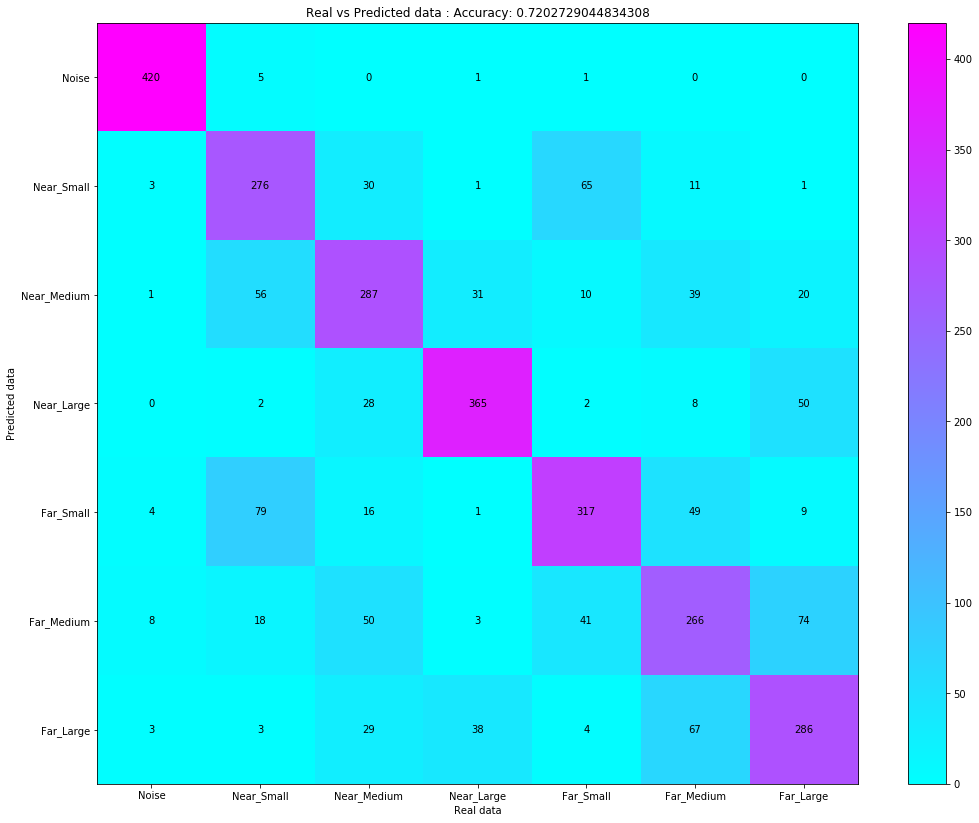

In [26]:
plot_confustion_matrix(y_test, y_pred, df,prob=False)

## Feature Importance

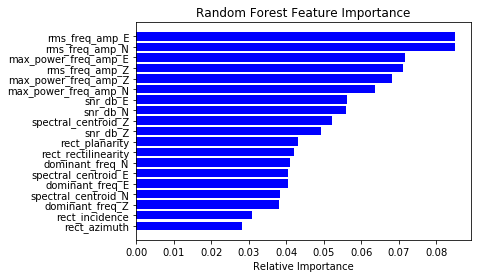

In [28]:
features = X_train.columns.tolist()
importances = rf_random.best_estimator_.feature_importances_
indices = np.argsort(importances)

plt.title('Random Forest Feature Importance')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Save model

In [30]:
pickle.dump(rf_random.best_estimator_, open('99_ML_Random_Forest_Baseline.pkl', 'wb'))

# Make submission predictions

In [2]:
df_submission = pd.read_pickle('../data/df_submission.pkl.gzip', compression='gzip')

In [3]:
print(df_submission.shape)
df_submission.head()

(20982, 17)


,trace_id,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,p_travel_sec,s_arrival_sample,source_origin_time,source_latitude,source_longitude,source_depth_km,snr_db_E,snr_db_N,snr_db_Z,E,N,Z
0,trace_500,37.85884,-121.99264,259.0,399.0,13.806000,892.0,2011-04-16 12:40:15.591,52.55610,-116.23017,1.50,31.299999,49.900002,27.0,"[-0.0, -0.00022036854, -0.0006564023, -0.00178...","[-0.0, -1.5555523e-05, -2.6436726e-05, -5.1018...","[-0.0, -6.6268326e-06, -5.566338e-07, 7.242038..."
1,trace_501,36.68011,-119.02282,1140.0,600.0,5.080000,2148.0,2011-03-12 15:54:01.040,36.57950,-149.94900,16.00,28.900000,25.799999,26.6,"[-0.0, -0.003910351, -0.0076862974, -0.0587444...","[0.0, 0.0111518, 0.031661604, 0.098408185, 0.1...","[-0.0, -0.019765988, -0.061188668, -0.15370083..."
2,trace_502,60.19520,-154.32010,96.0,500.0,11.440000,1764.0,2015-03-25 00:10:57.680,37.66467,-117.30250,81.18,35.299999,26.900000,19.9,"[38.845078, 41.64532, 39.854225, 33.39964, 23....","[-42.89445, -27.585876, -12.321886, 2.3429925,...","[-21.905762, -5.8183093, 14.36668, 30.567423, ..."
3,trace_503,35.92920,-120.51530,583.0,700.0,10.580000,1216.5,2018-04-21 13:34:42.190,54.22590,17.02430,14.11,35.599998,37.599998,24.4,"[-0.0, -0.00024849953, -9.589619e-05, -0.00362...","[0.0, 0.00030432147, 0.0017123658, 0.004246875...","[0.0, 0.00016073156, 0.0014357661, 0.00039703,..."
4,trace_504,36.19250,-117.66850,1859.9,900.0,17.969999,921.0,2014-10-29 06:26:22.730,37.02580,-116.25717,6.16,27.299999,27.700001,24.6,"[0.0, 0.00027774205, -0.00014372196, -0.002718...","[-0.0, -2.7009946e-05, 0.00095413084, 0.001883...","[0.0, 0.0003360864, 0.0004533975, 0.0011395814..."


## Apply pre-processing

In [4]:
from PreProcessing import preprocess

/opt/anaconda3/lib/python3.7/site-packages/obspy/signal/headers.py:93: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ], align=True)


In [5]:
X_submission = preprocess(df_submission)

     Processing - Degree of rectiliniarity (polarization)
     Starting Trace-By-Trace feature processing
          Processing Spectral Centroid
          RMS of frequency amplitude
          Maximum power of frequency amplitude
          Dominant frequency
          Processing Spectral Centroid
          RMS of frequency amplitude
          Maximum power of frequency amplitude
          Dominant frequency
          Processing Spectral Centroid
          RMS of frequency amplitude
          Maximum power of frequency amplitude
          Dominant frequency


In [6]:
# load model if necessary
rf_random_best_estimator_ = pickle.load( open('99_ML_Random_Forest_Baseline.pkl', "rb" ) )

In [7]:
y_submission = rf_random_best_estimator_.predict(X_submission.drop(['trace_id'],axis=1))

In [8]:
df_result = pd.DataFrame({'trace_id' : df_submission['trace_id'], 'submission' : y_submission})

In [9]:
df_result

,trace_id,submission
0,trace_500,0
1,trace_501,5
2,trace_502,5
3,trace_503,5
4,trace_504,1
...,...,...
20995,trace_21495,4
20996,trace_21496,0
20997,trace_21497,4
20998,trace_21498,4


In [10]:
df_result.to_csv('./99_ML_Random_Forest_Baseline_Prediction.csv',index=False)

## Get Metrics as if on Platform

In [11]:
df_true = pd.read_csv('./submissions_true.csv')

In [12]:
df_merge = pd.merge(left=df_true, right=df_result, left_on='trace_id', right_on='trace_id', how='left')
y_true = df_merge['true_label']
y_pred = df_merge['submission']

In [13]:
print('precision_score :', precision_score(y_true, y_pred, average='weighted'))
print('recall_score :', recall_score(y_true, y_pred, average='weighted'))
print('f1_score :', f1_score(y_true, y_pred, average='weighted'))
print('balanced_accuracy_score :', balanced_accuracy_score(y_true, y_pred))

precision_score : 0.7245476045255589
recall_score : 0.7240968449146887
f1_score : 0.7234004336579665
balanced_accuracy_score : 0.7241070955796992
